# GEONE - GEOSCLASSIC - Examples in 2D

## Estimation (kriging) and simulation (Sequential Gaussian Simulation, SGS)

See notebook `ex_geosclassic_1d_1.ipynb` for detail explanations about estimation (kriging) and simulation (Sequential Gaussian Simulation, SGS) in a grid.

## Examples in 2D
In this notebook, examples in 2D with a stationary covariance model are given.

*Remark: for examples with non-stationary covariance models in 2D, see jupyter notebook `ex_geosclassic_2d_2_non_stat_cov.ipynb`.*




## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


### Remark
The matplotlib figures can be visualized in *interactive* mode:

- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Grid (2D)

In [3]:
nx, ny = 220, 230  # number of cells
sx, sy = 1.0, 1.0  # cell unit
ox, oy = 0.0, 0.0  # origin

dimension = (nx, ny)
spacing = (sx, sy)
origin = (ox, oy)

## Covariance model

In 2D, a covariance model is given by an instance of the class `geone.covModel.covModel2D` (or `geone.covModel.covModel1D` for omni-directional (isotropic) case).

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

An azimuth angle, `alpha`, can be specified in degrees: the coordinates system Ox'y' supporting the axes of the model (ranges) is obtained from the original coordinates system Oxy by applying a rotation of `-alpha` (i.e. clockwise for positive angle).

*Note: see the notebook `ex_general_multiGaussian.ipynb` for available covariance models and examples.*

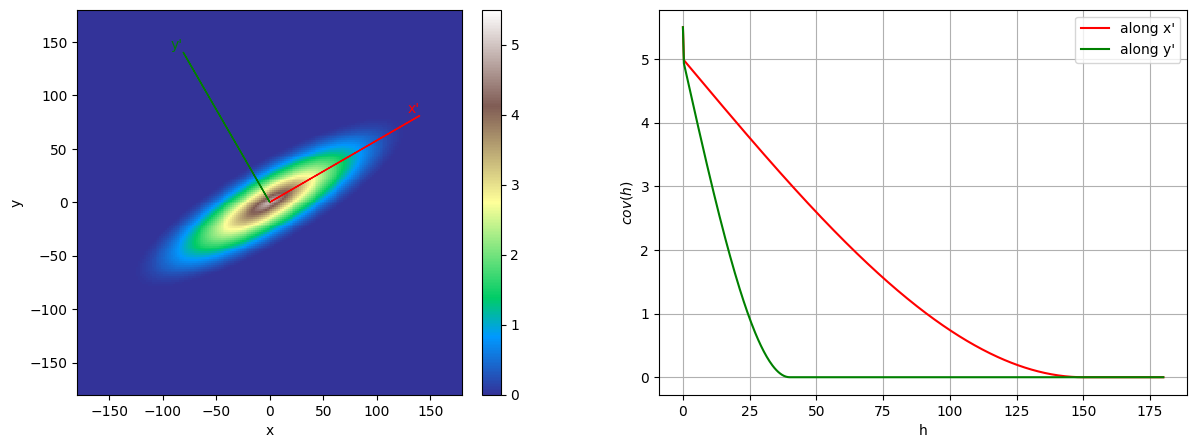

In [4]:
cov_model = gn.covModel.CovModel2D(elem=[
    ('spherical', {'w':5., 'r':[150, 40]}), # elementary contribution
    ('nugget', {'w':.5})                    # elementary contribution
    ], alpha=-30, name='model-2D example')

cov_model.plot_model(figsize=(15,5))
plt.suptitle('')
plt.show()

## 1. Example - Set-up

In [5]:
# Data
x = np.array([[ 10.5 ,  20.5 ],  
              [ 50.82,  40.25],  
              [ 20.34, 150.95],  
              [200.52, 210.74]]) # data locations (real coordinates)
v = [ -3.,  2.,   5.,  -1.]  # data values
# v_err_std = 0.0                  # data error standard deviation
v_err_std = [0.0, 0.0, 0.3, 1.0]   # data error standard deviation
                                   #   float: same for all data points
                                   #   list or array: per data point

# Inequality data
x_ineq = np.array([[ 175.5 ,  60.5 ],
                   [ 125.95, 100.82], 
                   [  75.34, 175.35]]) # locations (real coordinates)
v_ineq_min = [  -2.2,    4.0 ,  np.nan]  # lower bounds
v_ineq_max = [  -1.4, np.nan,   -4.1]    # upper bounds
# x_ineq = None
# v_ineq_min = None
# v_ineq_max = None

# Type of kriging
method = 'simple_kriging'


### Estimation (kriging)

In [6]:
# Computational resources
nthreads = 8
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

# Seed (used for simulation at ineq. data points)
seed = 913

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            method=method,                 # type of kriging
                            use_unique_neighborhood=True,  # search neighborhood ...
                            searchRadius=None,             # ... used for simulation at ineq. data points
                            searchRadiusRelative=4.0, 
                            nneighborMax=12,
                            seed=seed,                     # seed (used for simulation at ineq. data points)
                            nthreads=nthreads,             # computational resources
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image

estimate: Preprocessing data done: final number of data points : 4, inequality data points: 3
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1.1) Do sgs at inequality data points (100 simulation(s) at 3 points)...
estimate: (Step 1.2) Transform inequality data to equality data with error std...
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
estimate: warnings encountered (14 times in all):
#  1: WARNING 02015: 

In [7]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(14, ['WARNING 02015: solving kriging system fails (do as if no neighbor)'])

### Simulations

In [8]:
# Number of realizations
nreal = 250

# Seed
seed = 321

# Simulation mode (in case where there is inequality data)
mode_transform_ineq_to_data = False # Transform ineq. to data with err ?

# Computational resources
nproc = 2
nthreads_per_proc = 4
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            mode_transform_ineq_to_data=mode_transform_ineq_to_data,
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 3
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1.1) Do sgs at inequality data points (250 simulation(s) at 3 points)...
simulate: (Step 2-4): Krige + Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     0 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     1 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     2 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     3 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     4 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     5 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     6 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     7 of 124...
_run

In [9]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(2,
 [np.str_('WARNING 02001: a neigbhor has been dropped (solving kriging system)'),
  np.str_('WARNING 02015: solving kriging system fails (do as if no neighbor)')])

### Plot the results

In [10]:
# Compute mean and standard deviation (pixel-wise)
simul_img_mean = gn.img.imageContStat(simul_img, op='mean')
simul_img_std  = gn.img.imageContStat(simul_img, op='std')

# Compute min and max (pixel-wise)
simul_img_min = gn.img.imageContStat(simul_img, op='min')
simul_img_max = gn.img.imageContStat(simul_img, op='max')

# Compute quantile (pixel-wise)
q = (0.025, 0.5, 0.975)
simul_img_q = gn.img.imageContStat(simul_img, op='quantile', q=q)


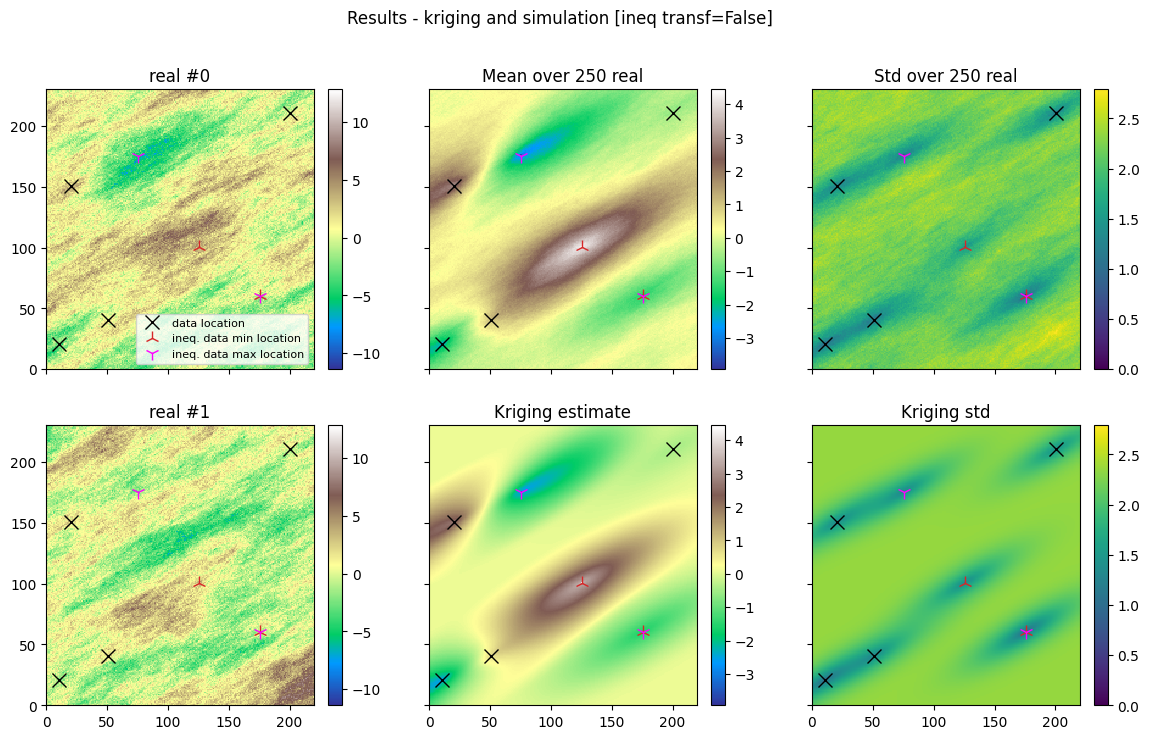

In [11]:
# Plot simulations and kriging results
vmin = simul_img.val.min()
vmax = simul_img.val.max()

mean_min = min(simul_img_mean.val.min(), krig_img.val[0].min())
mean_max = max(simul_img_mean.val.max(), krig_img.val[0].max())

std_min = min(simul_img_std.val.min(), krig_img.val[1].min())
std_max = max(simul_img_std.val.max(), krig_img.val[1].max())

cmap = 'terrain'
cmap_mean = 'terrain'
cmap_std = 'viridis'

def plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max):
    if x is not None:
        # add data
        plt.plot(x[:,0],x[:,1], 'x', c='k', alpha=1.0, markersize=10, label='data location')
    if x_ineq is not None:
         # add inequality data, lower bound
        label = 'ineq. data min location'
        for i, vv in enumerate(v_ineq_min): 
            if not np.isnan(vv):
                plt.plot(*x_ineq[i], '2', c='tab:red', alpha=1.0, markersize=10, label=label)
                label = None
        # add inequality data, upper bound
        label = 'ineq. data max location'
        for i, vv in enumerate(v_ineq_max):
            if not np.isnan(vv):
                plt.plot(*x_ineq[i], '1', c='magenta', alpha=1.0, markersize=10, label=label)
                label = None

fig, ax = plt.subplots(2, 3, figsize=(14,8), sharex=True, sharey=True)
# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 3, 3*i+1)
    gn.imgplot.drawImage2D(simul_img, iv=i, cmap=cmap, vmin=vmin, vmax=vmax)
    plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
    plt.title(f'real #{i}')
    if i == 0:
        plt.legend(fontsize=8)

# mean
plt.subplot(2, 3, 2)
gn.imgplot.drawImage2D(simul_img_mean, iv=0, cmap=cmap_mean, vmin=mean_min, vmax=mean_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Mean over {nreal} real')

# std
plt.subplot(2, 3, 3)
gn.imgplot.drawImage2D(simul_img_std, iv=0, cmap=cmap_std, vmin=std_min, vmax=std_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Std over {nreal} real')

# kriging estimate
plt.subplot(2, 3, 5)
gn.imgplot.drawImage2D(krig_img, iv=0, cmap=cmap_mean, vmin=mean_min, vmax=mean_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Kriging estimate')

# kriging std
plt.subplot(2, 3, 6)
gn.imgplot.drawImage2D(krig_img, iv=1, cmap=cmap_std, vmin=std_min, vmax=std_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Kriging std')

plt.suptitle(f'Results - kriging and simulation [ineq transf={mode_transform_ineq_to_data}]')
plt.show()

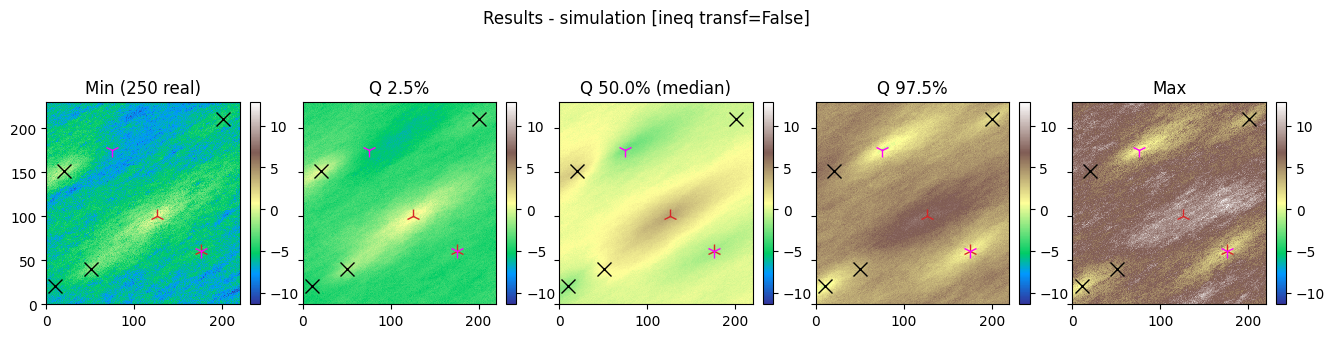

In [12]:
# Plot min, max, and quantiles of simulations
fig, ax = plt.subplots(1, 5, figsize=(16,4), sharex=True, sharey=True)

# min
plt.subplot(1, 5, 1)
gn.imgplot.drawImage2D(simul_img_min, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Min ({nreal} real)')

# Q
plt.subplot(1, 5, 2)
gn.imgplot.drawImage2D(simul_img_q, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Q {100*q[0]:.1f}%')

plt.subplot(1, 5, 3)
gn.imgplot.drawImage2D(simul_img_q, iv=1, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Q {100*q[1]:.1f}% (median)')

plt.subplot(1, 5, 4)
gn.imgplot.drawImage2D(simul_img_q, iv=2, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Q {100*q[2]:.1f}%')

# max
plt.subplot(1, 5, 5)
gn.imgplot.drawImage2D(simul_img_max, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Max')

plt.suptitle(f'Results - simulation [ineq transf={mode_transform_ineq_to_data}]')
plt.show()

### Detailed results around data points

In [13]:
# Get data error std (array)
data_err_std = np.atleast_1d(v_err_std)
if data_err_std.size==1:
    data_err_std = np.ones_like(v)*data_err_std[0]

# Get index of conditioning location in the grid
data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], 0, sx, sy, 1., ox, oy, 0.) for xk in x] # (ix, iy, iz) for each data point
# Coordinate of cell center containing the data points
x_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix]] for ix, iy, iz in data_grid_index])

print('Data location:\n', x)
print('Data cell center loc.:\n', x_center)
print('Is close to cell center ?\n', np.isclose(x, x_center).all(axis=1))


Data location:
 [[ 10.5   20.5 ]
 [ 50.82  40.25]
 [ 20.34 150.95]
 [200.52 210.74]]
Data cell center loc.:
 [[ 10.5  20.5]
 [ 50.5  40.5]
 [ 20.5 150.5]
 [200.5 210.5]]
Is close to cell center ?
 [ True False False False]


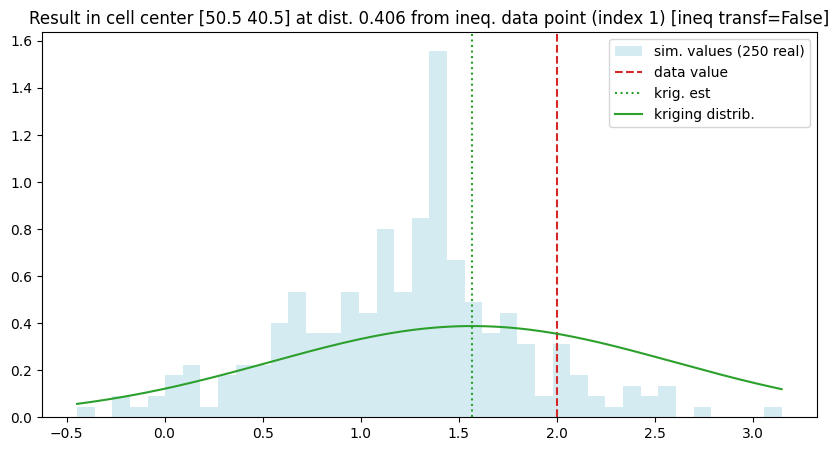

In [14]:
# Show results around one data point
# ----------------------------------
# Choose data index
j = 1

d = np.sqrt(np.sum((x[j] - x_center[j])**2))        # distance from cell center to data location
ix, iy, iz = data_grid_index[j]                     # grid index of cell containing the data point
sim_v = simul_img.val[:, iz, iy, ix]                # simulated values at cell center
krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix] # kriging estimate and std at cell center

t = np.linspace(sim_v.min(), sim_v.max(), 200)

# Plot
plt.figure(figsize=(10, 5))

plt.hist(sim_v, bins=40, density=True, color='lightblue', alpha=0.5, label=f'sim. values ({nreal} real)')
plt.axvline(v[j], c='tab:red', ls='dashed', label='data value')

if data_err_std[j] > 0:
    plt.plot(t, scipy.stats.norm(loc=v[j], scale=data_err_std[j]).pdf(t), c='tab:red', ls='solid', label='data distrib. (acc. for err.)')

plt.axvline(krig_v_mu, c='tab:green', ls='dotted', label='krig. est')
if krig_v_std > 0:
    plt.plot(t, scipy.stats.norm(loc=krig_v_mu, scale=krig_v_std).pdf(t), c='tab:green', ls='solid', label='kriging distrib.')

plt.legend()
plt.title(f'Result in cell center {x_center[j]} at dist. {d:.3g} from ineq. data point (index {j}) [ineq transf={mode_transform_ineq_to_data}]')
plt.show()


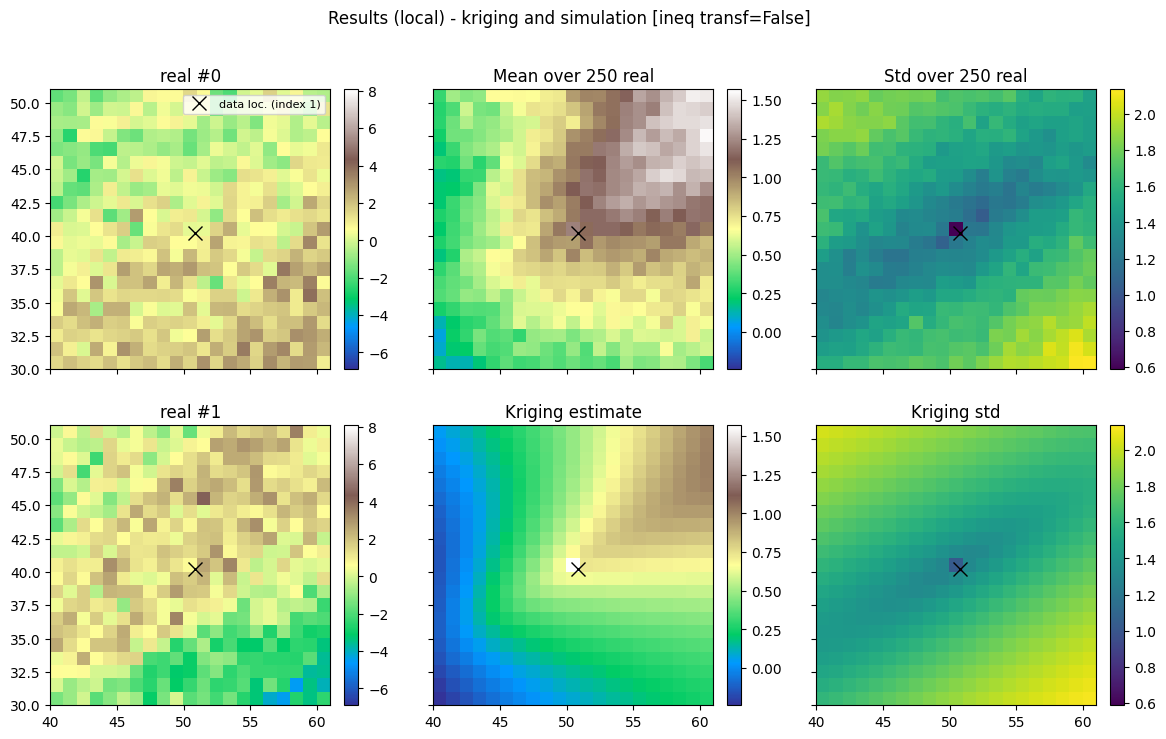

In [15]:
# Plot around selected point
# --------------------------

# Extract part of the images
simul_img_tmp = gn.img.copyImg(simul_img)
simul_img_tmp.resize(ix0=ix-10, ix1=ix+11, iy0=iy-10, iy1=iy+11)
krig_img_tmp = gn.img.copyImg(krig_img)
krig_img_tmp.resize(ix0=ix-10, ix1=ix+11, iy0=iy-10, iy1=iy+11)

# ... compute mean and standard deviation (pixel-wise)
simul_img_tmp_mean = gn.img.imageContStat(simul_img_tmp, op='mean')
simul_img_tmp_std  = gn.img.imageContStat(simul_img_tmp, op='std')

# ... compute min and max (pixel-wise)
simul_img_tmp_min = gn.img.imageContStat(simul_img_tmp, op='min')
simul_img_tmp_max = gn.img.imageContStat(simul_img_tmp, op='max')

# ... compute quantile (pixel-wise)
q = (0.025, 0.5, 0.975)
simul_img_tmp_q = gn.img.imageContStat(simul_img_tmp, op='quantile', q=q)

vmin = simul_img_tmp.val.min()
vmax = simul_img_tmp.val.max()

mean_min = min(simul_img_tmp_mean.val.min(), krig_img_tmp.val[0].min())
mean_max = max(simul_img_tmp_mean.val.max(), krig_img_tmp.val[0].max())

std_min = min(simul_img_tmp_std.val.min(), krig_img_tmp.val[1].min())
std_max = max(simul_img_tmp_std.val.max(), krig_img_tmp.val[1].max())

cmap = 'terrain'
cmap_mean = 'terrain'
cmap_std = 'viridis'

fig, ax = plt.subplots(2, 3, figsize=(14,8), sharex=True, sharey=True)
# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 3, 3*i+1)
    gn.imgplot.drawImage2D(simul_img_tmp, iv=i, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.plot(x[j,0],x[j,1], 'x', c='k', alpha=1.0, markersize=10, label=f'data loc. (index {j})') # add data
    plt.title(f'real #{i}')
    if i == 0:
        plt.legend(fontsize=8)

# mean
plt.subplot(2, 3, 2)
gn.imgplot.drawImage2D(simul_img_tmp_mean, iv=0, cmap=cmap_mean, vmin=mean_min, vmax=mean_max)
plt.plot(x[j,0],x[j,1], 'x', c='k', alpha=1.0, markersize=10) # add data
plt.title(f'Mean over {nreal} real')

# std
plt.subplot(2, 3, 3)
gn.imgplot.drawImage2D(simul_img_tmp_std, iv=0, cmap=cmap_std, vmin=std_min, vmax=std_max)
plt.plot(x[j,0],x[j,1], 'x', c='k', alpha=1.0, markersize=10) # add data
plt.title(f'Std over {nreal} real')

# kriging estimate
plt.subplot(2, 3, 5)
gn.imgplot.drawImage2D(krig_img_tmp, iv=0, cmap=cmap_mean, vmin=mean_min, vmax=mean_max)
plt.plot(x[j,0],x[j,1], 'x', c='k', alpha=1.0, markersize=10) # add data
plt.title(f'Kriging estimate')

# kriging std
plt.subplot(2, 3, 6)
gn.imgplot.drawImage2D(krig_img_tmp, iv=1, cmap=cmap_std, vmin=std_min, vmax=std_max)
plt.plot(x[j,0],x[j,1], 'x', c='k', alpha=1.0, markersize=10) # add data
plt.title(f'Kriging std')

plt.suptitle(f'Results (local) - kriging and simulation [ineq transf={mode_transform_ineq_to_data}]')
plt.show()

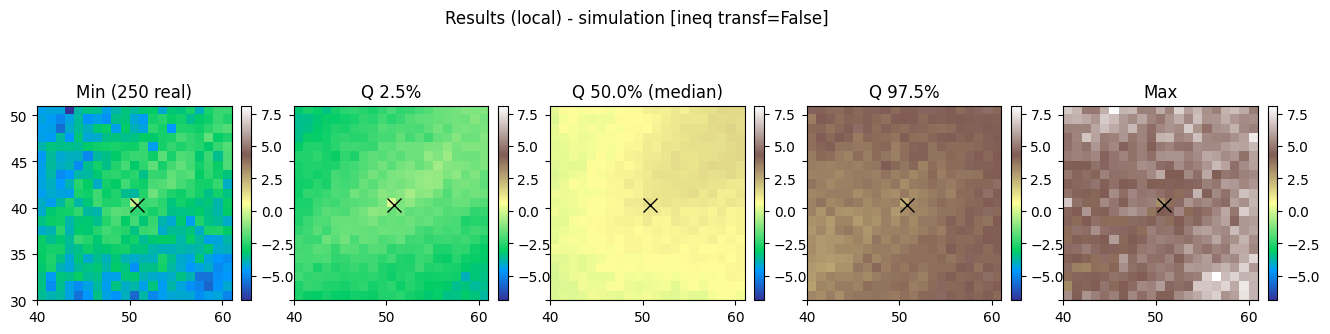

In [16]:
# Plot min, max, and quantiles of simulations
fig, ax = plt.subplots(1, 5, figsize=(16,4), sharex=True, sharey=True)

# min
plt.subplot(1, 5, 1)
gn.imgplot.drawImage2D(simul_img_tmp_min, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plt.plot(x[j,0],x[j,1], 'x', c='k', alpha=1.0, markersize=10) # add data
plt.title(f'Min ({nreal} real)')

# Q
plt.subplot(1, 5, 2)
gn.imgplot.drawImage2D(simul_img_tmp_q, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plt.plot(x[j,0],x[j,1], 'x', c='k', alpha=1.0, markersize=10) # add data
plt.title(f'Q {100*q[0]:.1f}%')

plt.subplot(1, 5, 3)
gn.imgplot.drawImage2D(simul_img_tmp_q, iv=1, cmap=cmap, vmin=vmin, vmax=vmax)
plt.plot(x[j,0],x[j,1], 'x', c='k', alpha=1.0, markersize=10) # add data
plt.title(f'Q {100*q[1]:.1f}% (median)')

plt.subplot(1, 5, 4)
gn.imgplot.drawImage2D(simul_img_tmp_q, iv=2, cmap=cmap, vmin=vmin, vmax=vmax)
plt.plot(x[j,0],x[j,1], 'x', c='k', alpha=1.0, markersize=10) # add data
plt.title(f'Q {100*q[2]:.1f}%')

# max
plt.subplot(1, 5, 5)
gn.imgplot.drawImage2D(simul_img_tmp_max, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plt.plot(x[j,0],x[j,1], 'x', c='k', alpha=1.0, markersize=10) # add data
plt.title(f'Max')

plt.suptitle(f'Results (local) - simulation [ineq transf={mode_transform_ineq_to_data}]')
plt.show()

### Detailed results around inequality data points

In [17]:
# Get index of conditioning location in the grid
ineq_data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], 0, sx, sy, 1., ox, oy, 0.) for xk in x_ineq] # (ix, iy, iz) for each data point
# Coordinate of cell center containing the inequality data points
x_ineq_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix]] for ix, iy, iz in ineq_data_grid_index])

print('Inequality location:\n', x_ineq)
print('Inequality cell center loc.:\n', x_ineq_center)
print('Is close to cell center ?\n', np.isclose(x_ineq, x_ineq_center).all(axis=1))


Inequality location:
 [[175.5   60.5 ]
 [125.95 100.82]
 [ 75.34 175.35]]
Inequality cell center loc.:
 [[175.5  60.5]
 [125.5 100.5]
 [ 75.5 175.5]]
Is close to cell center ?
 [ True False False]


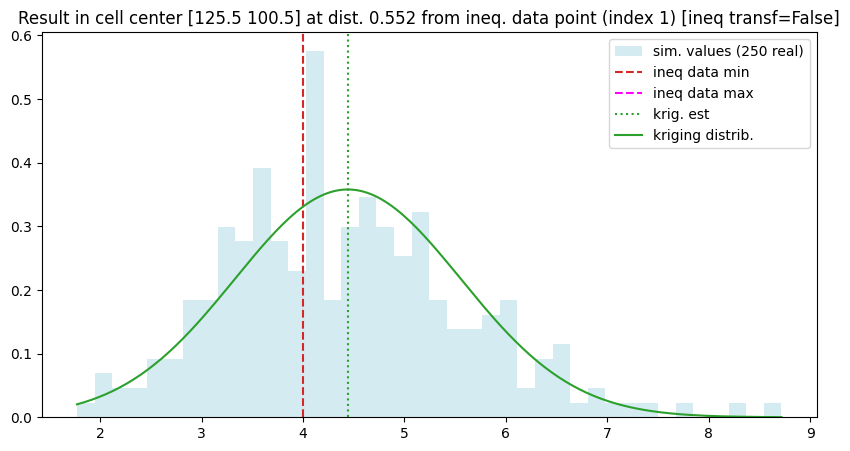

In [18]:
# Show results around one inequality data point
# ----------------------------------------------
# Choose inequality data index
j = 1

d = np.sqrt(np.sum((x_ineq[j] - x_ineq_center[j])**2)) # distance from cell center to inequality data location
ix, iy, iz = ineq_data_grid_index[j]                   # grid index of cell containing the inequality data point
sim_v = simul_img.val[:, iz, iy, ix]                   # simulated values at cell center
krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]    # kriging estimate and std at cell center

t = np.linspace(sim_v.min(), sim_v.max(), 200)

# Plot
plt.figure(figsize=(10, 5))

plt.hist(sim_v, bins=40, density=True, color='lightblue', alpha=0.5, label=f'sim. values ({nreal} real)')
plt.axvline(v_ineq_min[j], c='tab:red', ls='dashed', label='ineq data min') # not necessarily present (could be nan)
plt.axvline(v_ineq_max[j], c='magenta', ls='dashed', label='ineq data max') # not necessarily present (could be nan)

plt.axvline(krig_v_mu, c='tab:green', ls='dotted', label='krig. est')
if krig_v_std > 0:
    plt.plot(t, scipy.stats.norm(loc=krig_v_mu, scale=krig_v_std).pdf(t), c='tab:green', ls='solid', label='kriging distrib.')

plt.legend()
plt.title(f'Result in cell center {x_ineq_center[j]} at dist. {d:.3g} from ineq. data point (index {j}) [ineq transf={mode_transform_ineq_to_data}]')
plt.show()


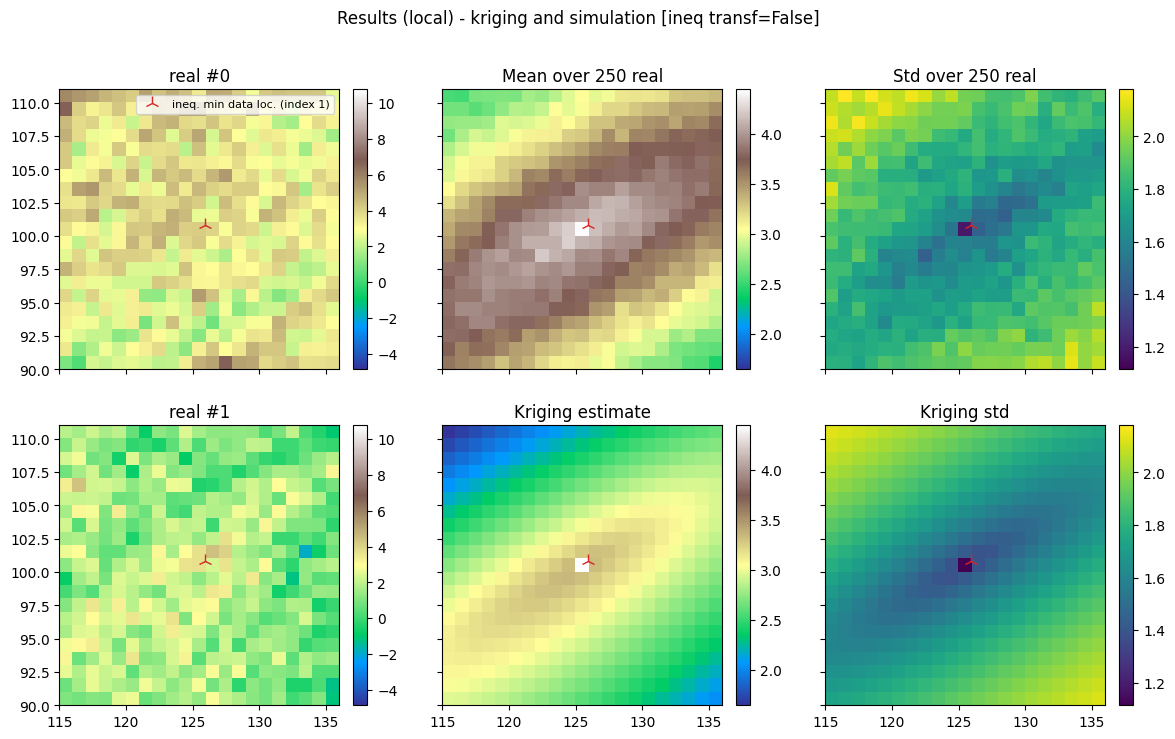

In [19]:
# Plot around selected point
# --------------------------

# Extract part of the images
simul_img_tmp = gn.img.copyImg(simul_img)
simul_img_tmp.resize(ix0=ix-10, ix1=ix+11, iy0=iy-10, iy1=iy+11)
krig_img_tmp = gn.img.copyImg(krig_img)
krig_img_tmp.resize(ix0=ix-10, ix1=ix+11, iy0=iy-10, iy1=iy+11)

# ... compute mean and standard deviation (pixel-wise)
simul_img_tmp_mean = gn.img.imageContStat(simul_img_tmp, op='mean')
simul_img_tmp_std  = gn.img.imageContStat(simul_img_tmp, op='std')

# ... compute min and max (pixel-wise)
simul_img_tmp_min = gn.img.imageContStat(simul_img_tmp, op='min')
simul_img_tmp_max = gn.img.imageContStat(simul_img_tmp, op='max')

# ... compute quantile (pixel-wise)
q = (0.025, 0.5, 0.975)
simul_img_tmp_q = gn.img.imageContStat(simul_img_tmp, op='quantile', q=q)

vmin = simul_img_tmp.val.min()
vmax = simul_img_tmp.val.max()

mean_min = min(simul_img_tmp_mean.val.min(), krig_img_tmp.val[0].min())
mean_max = max(simul_img_tmp_mean.val.max(), krig_img_tmp.val[0].max())

std_min = min(simul_img_tmp_std.val.min(), krig_img_tmp.val[1].min())
std_max = max(simul_img_tmp_std.val.max(), krig_img_tmp.val[1].max())

cmap = 'terrain'
cmap_mean = 'terrain'
cmap_std = 'viridis'

def plot_one_ineq_in_2d(j, x_ineq, v_ineq_min, v_ineq_max):
    if not np.isnan(v_ineq_min[j]):
        plt.plot(x_ineq[j, 0],x_ineq[j, 1], '2', c='tab:red', alpha=1.0, markersize=10, label=f'ineq. min data loc. (index {j})') # add ineq. data
    if not np.isnan(v_ineq_max[j]):
        plt.plot(x_ineq[j, 0],x_ineq[j, 1], '2', c='magenta', alpha=1.0, markersize=10, label=f'ineq. max data loc. (index {j})') # add ineq. data
    
fig, ax = plt.subplots(2, 3, figsize=(14,8), sharex=True, sharey=True)
# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 3, 3*i+1)
    gn.imgplot.drawImage2D(simul_img_tmp, iv=i, cmap=cmap, vmin=vmin, vmax=vmax)
    plot_one_ineq_in_2d(j, x_ineq, v_ineq_min, v_ineq_max) # add ineq. data
    plt.title(f'real #{i}')
    if i == 0:
        plt.legend(fontsize=8)

# mean
plt.subplot(2, 3, 2)
gn.imgplot.drawImage2D(simul_img_tmp_mean, iv=0, cmap=cmap_mean, vmin=mean_min, vmax=mean_max)
plot_one_ineq_in_2d(j, x_ineq, v_ineq_min, v_ineq_max) # add ineq. data
plt.title(f'Mean over {nreal} real')

# std
plt.subplot(2, 3, 3)
gn.imgplot.drawImage2D(simul_img_tmp_std, iv=0, cmap=cmap_std, vmin=std_min, vmax=std_max)
plot_one_ineq_in_2d(j, x_ineq, v_ineq_min, v_ineq_max) # add ineq. data
plt.title(f'Std over {nreal} real')

# kriging estimate
plt.subplot(2, 3, 5)
gn.imgplot.drawImage2D(krig_img_tmp, iv=0, cmap=cmap_mean, vmin=mean_min, vmax=mean_max)
plot_one_ineq_in_2d(j, x_ineq, v_ineq_min, v_ineq_max) # add ineq. data
plt.title(f'Kriging estimate')

# kriging std
plt.subplot(2, 3, 6)
gn.imgplot.drawImage2D(krig_img_tmp, iv=1, cmap=cmap_std, vmin=std_min, vmax=std_max)
plot_one_ineq_in_2d(j, x_ineq, v_ineq_min, v_ineq_max) # add ineq. data
plt.title(f'Kriging std')

plt.suptitle(f'Results (local) - kriging and simulation [ineq transf={mode_transform_ineq_to_data}]')
plt.show()

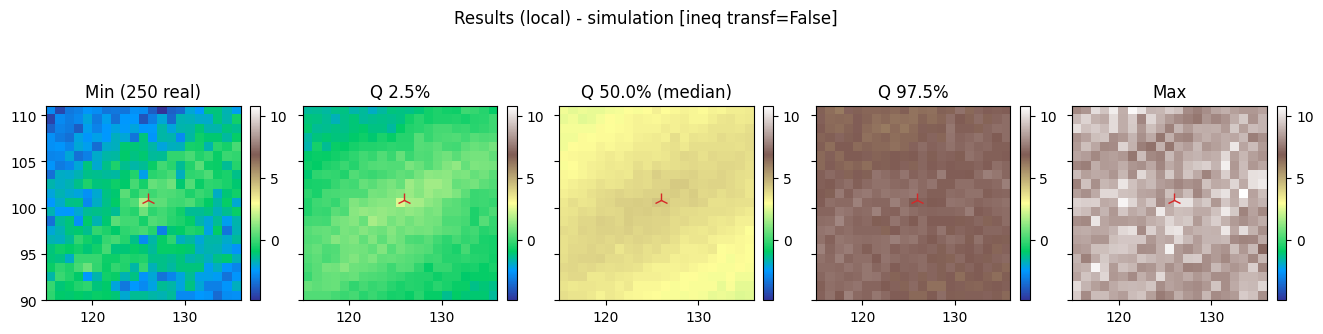

In [20]:
# Plot min, max, and quantiles of simulations
fig, ax = plt.subplots(1, 5, figsize=(16,4), sharex=True, sharey=True)

# min
plt.subplot(1, 5, 1)
gn.imgplot.drawImage2D(simul_img_tmp_min, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_one_ineq_in_2d(j, x_ineq, v_ineq_min, v_ineq_max) # add ineq. data
plt.title(f'Min ({nreal} real)')

# Q
plt.subplot(1, 5, 2)
gn.imgplot.drawImage2D(simul_img_tmp_q, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_one_ineq_in_2d(j, x_ineq, v_ineq_min, v_ineq_max) # add ineq. data
plt.title(f'Q {100*q[0]:.1f}%')

plt.subplot(1, 5, 3)
gn.imgplot.drawImage2D(simul_img_tmp_q, iv=1, cmap=cmap, vmin=vmin, vmax=vmax)
plot_one_ineq_in_2d(j, x_ineq, v_ineq_min, v_ineq_max) # add ineq. data
plt.title(f'Q {100*q[1]:.1f}% (median)')

plt.subplot(1, 5, 4)
gn.imgplot.drawImage2D(simul_img_tmp_q, iv=2, cmap=cmap, vmin=vmin, vmax=vmax)
plot_one_ineq_in_2d(j, x_ineq, v_ineq_min, v_ineq_max) # add ineq. data
plt.title(f'Q {100*q[2]:.1f}%')

# max
plt.subplot(1, 5, 5)
gn.imgplot.drawImage2D(simul_img_tmp_max, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_one_ineq_in_2d(j, x_ineq, v_ineq_min, v_ineq_max) # add ineq. data
plt.title(f'Max')

plt.suptitle(f'Results (local) - simulation [ineq transf={mode_transform_ineq_to_data}]')
plt.show()

### Check results
For each data point and inequality data point, the results obtained at the center of the grid cell containing the point are checked for
kriging (estimate or mean, with inequality data transform into data with error), and simulation (with or without ineq. data transform).

**Note:** Conditioning is "fully honoured" 
- for data points: located **exactly** in a cell center and with a **zero data error**
- for inequality data points: located **exactly** in a cell center and with `mode_transform_ineq_to_data=False`

In [21]:
# Check data
# ----------
if x is not None:
    # Get data error std (array)
    data_err_std = np.atleast_1d(v_err_std)
    if data_err_std.size==1:
        data_err_std = np.ones_like(v)*data_err_std[0]

    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], 0, sx, sy, 1., ox, oy, 0.) for xk in x] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the data points
    x_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix]] for ix, iy, iz in data_grid_index])
    # Distance to center cell
    dist_to_x_center = np.sqrt(np.sum((np.asarray(x) - np.asarray(x_center))**2, axis=1))

    # Check
    for j in range(len(x)):
        print(f'Data point index {j}, dist. to cell center = {dist_to_x_center[j]:.4g}')
        ix, iy, iz = data_grid_index[j]                      # grid index of cell containing the data point
        krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]  # kriging estimate and std at cell center
        sim_v = simul_img.val[:, iz, iy, ix]                 # simulated values at cell center
        print(f'   data value                         = {v[j]:.3e} [data error std = {data_err_std[j]:.3e}]')
        print(f'   krig. mean value [ineq transf=True] = {krig_v_mu:.3e} [krig. std = {krig_v_std:.3e}]')
        print(f'   simul. [ineq transf={str(mode_transform_ineq_to_data):<5}]   : mean = {sim_v.mean() :.3e}, min = {sim_v.min() :.3e}, max = {sim_v.max() :.3e} [std = {sim_v.std() :.3e}]')


Data point index 0, dist. to cell center = 0
   data value                         = -3.000e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = -3.000e+00 [krig. std = 0.000e+00]
   simul. [ineq transf=False]   : mean = -3.000e+00, min = -3.000e+00, max = -3.000e+00 [std = 0.000e+00]
Data point index 1, dist. to cell center = 0.4061
   data value                         = 2.000e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = 1.569e+00 [krig. std = 1.029e+00]
   simul. [ineq transf=False]   : mean = 1.217e+00, min = -4.461e-01, max = 3.147e+00 [std = 5.871e-01]
Data point index 2, dist. to cell center = 0.4776
   data value                         = 5.000e+00 [data error std = 3.000e-01]
   krig. mean value [ineq transf=True] = 4.062e+00 [krig. std = 1.082e+00]
   simul. [ineq transf=False]   : mean = 3.428e+00, min = 1.657e+00, max = 5.625e+00 [std = 8.435e-01]
Data point index 3, dist. to cell center = 0.2408
   data value               

In [22]:
# Check inequality data
# ---------------------
if x_ineq is not None:
    # Get index of conditioning location in the grid
    ineq_data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], 0, sx, sy, 1., ox, oy, 0.) for xk in x_ineq] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the inequality data points
    x_ineq_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix]] for ix, iy, iz in ineq_data_grid_index])
    # Distance to center cell
    dist_to_x_ineq_center = np.sqrt(np.sum((np.asarray(x_ineq) - np.asarray(x_ineq_center))**2, axis=1))

    # Check
    for j in range(len(x_ineq)):
        print(f'Ineq. data point index {j}, dist. to cell center = {dist_to_x_ineq_center[j]:.4g}')
        ix, iy, iz = ineq_data_grid_index[j]     # grid index of cell containing the inequality data point
        krig_v_mu = krig_img.val[0, iz, iy, ix]  # kriging estimate at cell center
        sim_v = simul_img.val[:, iz, iy, ix]     # simulated values at cell center
        if not np.isnan(v_ineq_min[j]) and not np.isinf(v_ineq_min[j]):
            print(f'   does kriging mean value respect ineq data min [ineq transf=True] : {krig_v_mu >= v_ineq_min[j]}')
            print(f'   percentage of simul. respecting ineq data min [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v >= v_ineq_min[j]):.3f}%')
        if not np.isnan(v_ineq_max[j]) and not np.isinf(v_ineq_max[j]):
            print(f'   does kriging mean value respect ineq data max [ineq transf=True] : {krig_v_mu <= v_ineq_max[j]}')
            print(f'   percentage of simul. respecting ineq data max [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v <= v_ineq_max[j]):.3f}%')


Ineq. data point index 0, dist. to cell center = 0
   does kriging mean value respect ineq data min [ineq transf=True] : True
   percentage of simul. respecting ineq data min [ineq transf=False]: 100.000%
   does kriging mean value respect ineq data max [ineq transf=True] : True
   percentage of simul. respecting ineq data max [ineq transf=False]: 100.000%
Ineq. data point index 1, dist. to cell center = 0.5522
   does kriging mean value respect ineq data min [ineq transf=True] : True
   percentage of simul. respecting ineq data min [ineq transf=False]: 61.600%
Ineq. data point index 2, dist. to cell center = 0.2193
   does kriging mean value respect ineq data max [ineq transf=True] : False
   percentage of simul. respecting ineq data max [ineq transf=False]: 29.600%


## 2. Example with imposed mean and/or variance (simple kriging only)
Mean and variance in the simulation grid can be specified if simple kriging is used, they can be stationary (constant) or non-stationary. By default, the mean is set to the mean of data values (or zero if no conditioning data) (constant) and the variance is given by the sill of the variogram model (constant).


### 2.1 Constant mean and variance
Set mean to $5.0$ and variance to the double of the covariance model sill. No inequality is considered in this example.

In [23]:
# Data
x = np.array([[ 10.5 ,  20.5 ],  
              [ 50.82,  40.25],  
              [ 20.34, 150.95],  
              [200.52, 210.74]]) # data locations (real coordinates)
v = [ -3.,  2.,   5.,  -1.]  # data values
# v_err_std = 0.0                  # data error standard deviation
v_err_std = [0.0, 0.0, 0.3, 1.0]   # data error standard deviation
                                   #   float: same for all data points
                                   #   list or array: per data point

# Inequality data
x_ineq = np.array([[ 175.5 ,  60.5 ],
                   [ 125.95, 100.82], 
                   [  75.34, 175.35]]) # locations (real coordinates)
v_ineq_min = [  -2.2,    4.0 ,  np.nan]  # lower bounds
v_ineq_max = [  -1.4, np.nan,   -4.1]    # upper bounds
# x_ineq = None
# v_ineq_min = None
# v_ineq_max = None

# Specify mean and variance
mean = 5.0
var = 2.0 * cov_model.sill()

### Estimation (kriging)

In [24]:
# Computational resources
nthreads = 8
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

# Seed (used for simulation at ineq. data points)
seed = 913

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max,
                            mean=mean,                     # mean
                            var=var,                       # variance
                            method='simple_kriging',       # type of kriging
                            use_unique_neighborhood=True,  # search neighborhood ...
                            searchRadius=None,             # ... used for simulation at ineq. data points
                            searchRadiusRelative=4.0, 
                            nneighborMax=12,
                            seed=seed,                     # seed (used for simulation at ineq. data points)
                            nthreads=nthreads,             # computational resources
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image

estimate: Preprocessing data done: final number of data points : 4, inequality data points: 3
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1.1) Do sgs at inequality data points (100 simulation(s) at 3 points)...
estimate: (Step 1.2) Transform inequality data to equality data with error std...
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
estimate: warnings encountered (16 times in all):
#  1: WARNING 02015: 

### Simulations

In [25]:
# Number of realizations
nreal = 250

# Seed
seed = 321

# Simulation mode (in case where there is inequality data)
mode_transform_ineq_to_data = False # Transform ineq. to data with err ?

# Computational resources
nproc = 2
nthreads_per_proc = 4
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            mean=mean,                     # mean
                            var=var,                       # variance
                            mode_transform_ineq_to_data=mode_transform_ineq_to_data,
                            method='simple_kriging',       # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 3
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1.1) Do sgs at inequality data points (250 simulation(s) at 3 points)...
simulate: (Step 2-4): Krige + Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     0 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     1 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     2 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     3 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     4 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     5 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     6 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     7 of 124...
_run

### Plot the results

In [26]:
# Compute mean and standard deviation (pixel-wise)
simul_img_mean = gn.img.imageContStat(simul_img, op='mean')
simul_img_std  = gn.img.imageContStat(simul_img, op='std')

# Compute min and max (pixel-wise)
simul_img_min = gn.img.imageContStat(simul_img, op='min')
simul_img_max = gn.img.imageContStat(simul_img, op='max')

# Compute quantile (pixel-wise)
q = (0.025, 0.5, 0.975)
simul_img_q = gn.img.imageContStat(simul_img, op='quantile', q=q)


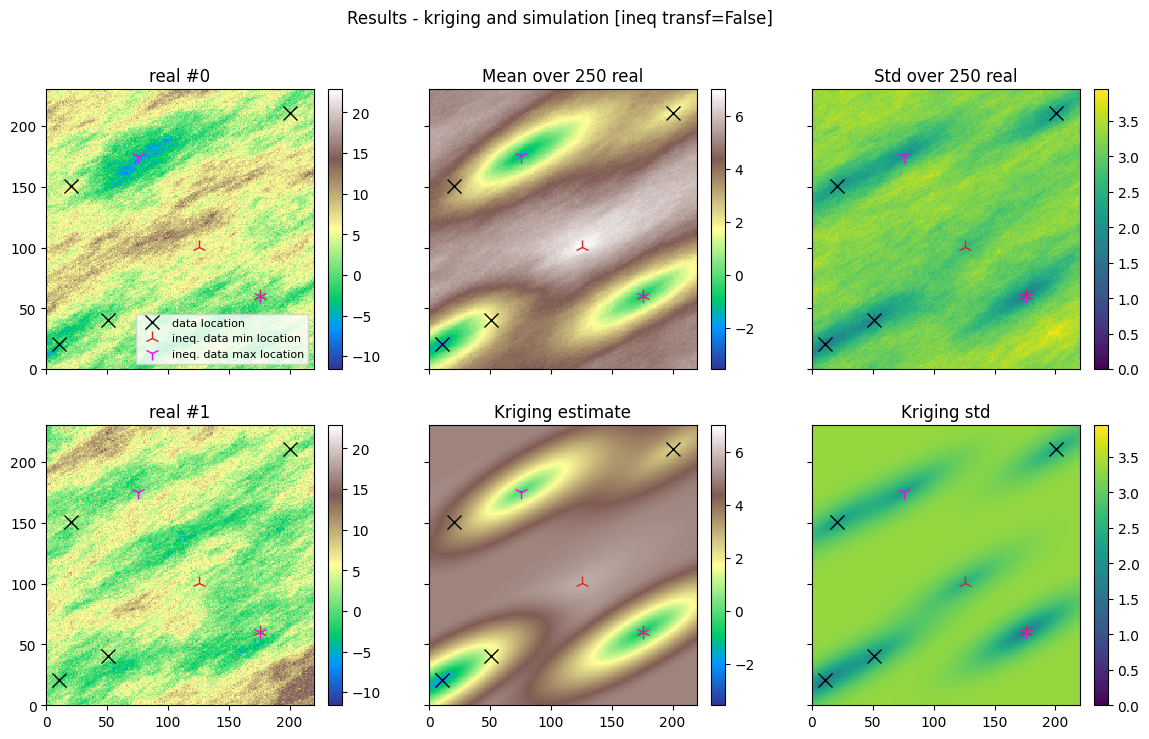

In [27]:
# Plot simulations and kriging results
vmin = simul_img.val.min()
vmax = simul_img.val.max()

mean_min = min(simul_img_mean.val.min(), krig_img.val[0].min())
mean_max = max(simul_img_mean.val.max(), krig_img.val[0].max())

std_min = min(simul_img_std.val.min(), krig_img.val[1].min())
std_max = max(simul_img_std.val.max(), krig_img.val[1].max())

cmap = 'terrain'
cmap_mean = 'terrain'
cmap_std = 'viridis'

def plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max):
    if x is not None:
        # add data
        plt.plot(x[:,0],x[:,1], 'x', c='k', alpha=1.0, markersize=10, label='data location')
    if x_ineq is not None:
         # add inequality data, lower bound
        label = 'ineq. data min location'
        for i, vv in enumerate(v_ineq_min): 
            if not np.isnan(vv):
                plt.plot(*x_ineq[i], '2', c='tab:red', alpha=1.0, markersize=10, label=label)
                label = None
        # add inequality data, upper bound
        label = 'ineq. data max location'
        for i, vv in enumerate(v_ineq_max):
            if not np.isnan(vv):
                plt.plot(*x_ineq[i], '1', c='magenta', alpha=1.0, markersize=10, label=label)
                label = None

fig, ax = plt.subplots(2, 3, figsize=(14,8), sharex=True, sharey=True)
# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 3, 3*i+1)
    gn.imgplot.drawImage2D(simul_img, iv=i, cmap=cmap, vmin=vmin, vmax=vmax)
    plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
    plt.title(f'real #{i}')
    if i == 0:
        plt.legend(fontsize=8)

# mean
plt.subplot(2, 3, 2)
gn.imgplot.drawImage2D(simul_img_mean, iv=0, cmap=cmap_mean, vmin=mean_min, vmax=mean_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Mean over {nreal} real')

# std
plt.subplot(2, 3, 3)
gn.imgplot.drawImage2D(simul_img_std, iv=0, cmap=cmap_std, vmin=std_min, vmax=std_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Std over {nreal} real')

# kriging estimate
plt.subplot(2, 3, 5)
gn.imgplot.drawImage2D(krig_img, iv=0, cmap=cmap_mean, vmin=mean_min, vmax=mean_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Kriging estimate')

# kriging std
plt.subplot(2, 3, 6)
gn.imgplot.drawImage2D(krig_img, iv=1, cmap=cmap_std, vmin=std_min, vmax=std_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Kriging std')

plt.suptitle(f'Results - kriging and simulation [ineq transf={mode_transform_ineq_to_data}]')
plt.show()

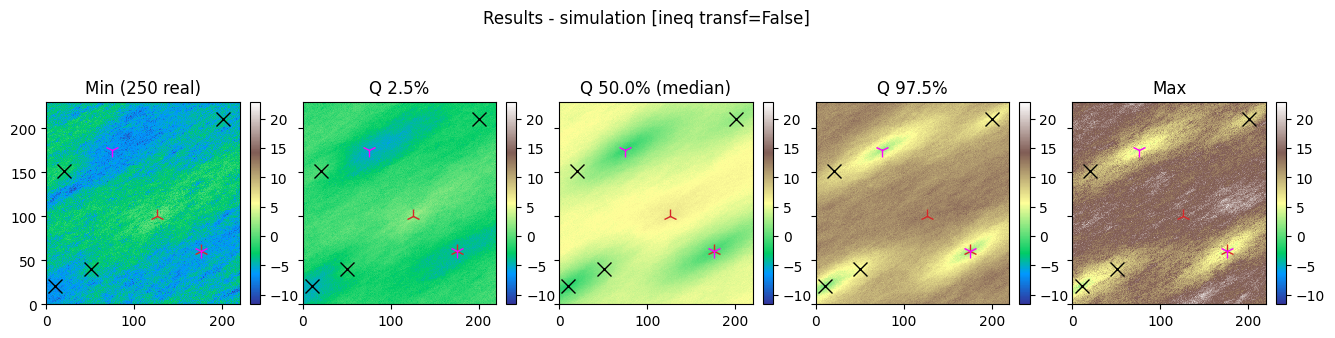

In [28]:
# Plot min, max, and quantiles of simulations
fig, ax = plt.subplots(1, 5, figsize=(16,4), sharex=True, sharey=True)

# min
plt.subplot(1, 5, 1)
gn.imgplot.drawImage2D(simul_img_min, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Min ({nreal} real)')

# Q
plt.subplot(1, 5, 2)
gn.imgplot.drawImage2D(simul_img_q, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Q {100*q[0]:.1f}%')

plt.subplot(1, 5, 3)
gn.imgplot.drawImage2D(simul_img_q, iv=1, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Q {100*q[1]:.1f}% (median)')

plt.subplot(1, 5, 4)
gn.imgplot.drawImage2D(simul_img_q, iv=2, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Q {100*q[2]:.1f}%')

# max
plt.subplot(1, 5, 5)
gn.imgplot.drawImage2D(simul_img_max, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Max')

plt.suptitle(f'Results - simulation [ineq transf={mode_transform_ineq_to_data}]')
plt.show()

### Check results
For each data point and inequality data point, the results obtained at the center of the grid cell containing the point are checked for
kriging (estimate or mean, with inequality data transform into data with error), and simulation (with or without ineq. data transform).

**Note:** Conditioning is "fully honoured" 
- for data points: located **exactly** in a cell center and with a **zero data error**
- for inequality data points: located **exactly** in a cell center and with `mode_transform_ineq_to_data=False`

In [29]:
# Check data
# ----------
if x is not None:
    # Get data error std (array)
    data_err_std = np.atleast_1d(v_err_std)
    if data_err_std.size==1:
        data_err_std = np.ones_like(v)*data_err_std[0]

    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], 0, sx, sy, 1., ox, oy, 0.) for xk in x] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the data points
    x_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix]] for ix, iy, iz in data_grid_index])
    # Distance to center cell
    dist_to_x_center = np.sqrt(np.sum((np.asarray(x) - np.asarray(x_center))**2, axis=1))

    # Check
    for j in range(len(x)):
        print(f'Data point index {j}, dist. to cell center = {dist_to_x_center[j]:.4g}')
        ix, iy, iz = data_grid_index[j]                      # grid index of cell containing the data point
        krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]  # kriging estimate and std at cell center
        sim_v = simul_img.val[:, iz, iy, ix]                 # simulated values at cell center
        print(f'   data value                         = {v[j]:.3e} [data error std = {data_err_std[j]:.3e}]')
        print(f'   krig. mean value [ineq transf=True] = {krig_v_mu:.3e} [krig. std = {krig_v_std:.3e}]')
        print(f'   simul. [ineq transf={str(mode_transform_ineq_to_data):<5}]   : mean = {sim_v.mean() :.3e}, min = {sim_v.min() :.3e}, max = {sim_v.max() :.3e} [std = {sim_v.std() :.3e}]')


Data point index 0, dist. to cell center = 0
   data value                         = -3.000e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = -3.000e+00 [krig. std = 0.000e+00]
   simul. [ineq transf=False]   : mean = -3.000e+00, min = -3.000e+00, max = -3.000e+00 [std = 0.000e+00]
Data point index 1, dist. to cell center = 0.4061
   data value                         = 2.000e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = 1.844e+00 [krig. std = 1.455e+00]
   simul. [ineq transf=False]   : mean = 1.696e+00, min = -1.471e+00, max = 5.376e+00 [std = 1.110e+00]
Data point index 2, dist. to cell center = 0.4776
   data value                         = 5.000e+00 [data error std = 3.000e-01]
   krig. mean value [ineq transf=True] = 4.476e+00 [krig. std = 1.530e+00]
   simul. [ineq transf=False]   : mean = 3.950e+00, min = 5.455e-01, max = 8.093e+00 [std = 1.604e+00]
Data point index 3, dist. to cell center = 0.2408
   data value               

In [30]:
# Check inequality data
# ---------------------
if x_ineq is not None:
    # Get index of conditioning location in the grid
    ineq_data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], 0, sx, sy, 1., ox, oy, 0.) for xk in x_ineq] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the inequality data points
    x_ineq_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix]] for ix, iy, iz in ineq_data_grid_index])
    # Distance to center cell
    dist_to_x_ineq_center = np.sqrt(np.sum((np.asarray(x_ineq) - np.asarray(x_ineq_center))**2, axis=1))

    # Check
    for j in range(len(x_ineq)):
        print(f'Ineq. data point index {j}, dist. to cell center = {dist_to_x_ineq_center[j]:.4g}')
        ix, iy, iz = ineq_data_grid_index[j]     # grid index of cell containing the inequality data point
        krig_v_mu = krig_img.val[0, iz, iy, ix]  # kriging estimate at cell center
        sim_v = simul_img.val[:, iz, iy, ix]     # simulated values at cell center
        if not np.isnan(v_ineq_min[j]) and not np.isinf(v_ineq_min[j]):
            print(f'   does kriging mean value respect ineq data min [ineq transf=True] : {krig_v_mu >= v_ineq_min[j]}')
            print(f'   percentage of simul. respecting ineq data min [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v >= v_ineq_min[j]):.3f}%')
        if not np.isnan(v_ineq_max[j]) and not np.isinf(v_ineq_max[j]):
            print(f'   does kriging mean value respect ineq data max [ineq transf=True] : {krig_v_mu <= v_ineq_max[j]}')
            print(f'   percentage of simul. respecting ineq data max [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v <= v_ineq_max[j]):.3f}%')


Ineq. data point index 0, dist. to cell center = 0
   does kriging mean value respect ineq data min [ineq transf=True] : True
   percentage of simul. respecting ineq data min [ineq transf=False]: 100.000%
   does kriging mean value respect ineq data max [ineq transf=True] : True
   percentage of simul. respecting ineq data max [ineq transf=False]: 100.000%
Ineq. data point index 1, dist. to cell center = 0.5522
   does kriging mean value respect ineq data min [ineq transf=True] : True
   percentage of simul. respecting ineq data min [ineq transf=False]: 90.000%
Ineq. data point index 2, dist. to cell center = 0.2193
   does kriging mean value respect ineq data max [ineq transf=True] : False
   percentage of simul. respecting ineq data max [ineq transf=False]: 14.400%


### 2.2 Non-stationary mean and variance
Set a varying mean and a varying variance over the simulation domain.

In [31]:
# Data
x = np.array([[ 10.5 ,  20.5 ],  
              [ 50.82,  40.25],  
              [ 20.34, 150.95],  
              [200.52, 210.74]]) # data locations (real coordinates)
v = [ -3.,  2.,   5.,  -1.]  # data values
# v_err_std = 0.0                  # data error standard deviation
v_err_std = [0.0, 0.0, 0.3, 1.0]   # data error standard deviation
                                   #   float: same for all data points
                                   #   list or array: per data point

# Inequality data
x_ineq = np.array([[ 175.5 ,  60.5 ],
                   [ 125.95, 100.82], 
                   [  75.34, 175.35]]) # locations (real coordinates)
v_ineq_min = [  -2.2,    4.0 ,  np.nan]  # lower bounds
v_ineq_max = [  -1.4, np.nan,   -4.1]    # upper bounds
# x_ineq = None
# v_ineq_min = None
# v_ineq_max = None

# Specify mean and variance
# - set mean as a function that take two parameters (x, y location) and returns a value
def mean_fun(x, y):
    return 0.1*(y - x)

# - set variance as a function that take two parameters (x, y location) and returns a value
def var_fun(x, y):
    return 1 + 0.1*(x + y)

# Note:
# ----
# In function `gn.geosclassicinterface.estimate` and `gn.geosclassicinterface.simulate`, 
# the parameters `mean` and `var` can also be array of values in the grid

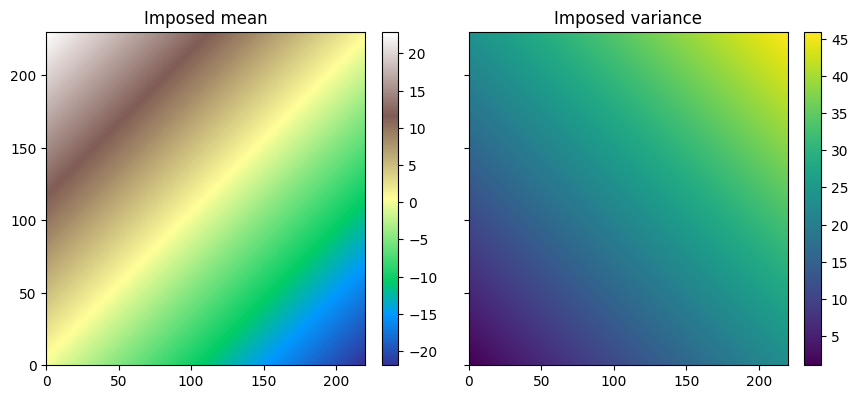

In [32]:
# Plot mean and var
# -----------------
# Set an image with grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=0)

# Get the x and y coordinates of the centers of grid cell (meshgrid)
xx = im.xx()[0]
yy = im.yy()[0]

# Equivalent:
## xg, yg: coordinates of the centers of grid cell
#xg = ox + 0.5*sx + sx*np.arange(nx)
#yg = oy + 0.5*sy + sy*np.arange(ny)
#xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of grid cells

# Define the mean and variance on the grid
mean = mean_fun(xx, yy)
var = var_fun(xx, yy)
# Equivalent: use the expression of the functions above
# mean = 0.1*(yy - xx) 
# var = 1 + 0.1*(xx + yy)

# Set variable mean and var in image im
im.append_var([mean, var], varname=['mean', 'var'])

# Display imposed mean and var
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)

plt.subplot(1, 2, 1)
gn.imgplot.drawImage2D(im, iv=0, cmap=cmap)
plt.title('Imposed mean')

plt.subplot(1, 2, 2)
gn.imgplot.drawImage2D(im, iv=1, cmap='viridis')
plt.title('Imposed variance')

plt.show()

### Estimation (kriging)

In [33]:
# Computational resources
nthreads = 8
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

# Seed (used for simulation at ineq. data points)
seed = 913

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max,
                            mean=mean_fun,                 # mean (or mean=mean)
                            var=var_fun,                   # variance (or var=var)
                            method='simple_kriging',       # type of kriging
                            use_unique_neighborhood=True,  # search neighborhood ...
                            searchRadius=None,             # ... used for simulation at ineq. data points
                            searchRadiusRelative=4.0, 
                            nneighborMax=12,
                            seed=seed,                     # seed (used for simulation at ineq. data points)
                            nthreads=nthreads,             # computational resources
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image

estimate: Preprocessing data done: final number of data points : 4, inequality data points: 3
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1.1) Do sgs at inequality data points (100 simulation(s) at 3 points)...
estimate: (Step 1.2) Transform inequality data to equality data with error std...
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
estimate: warnings encountered (25 times in all):
#  1: WARNING 02015: 

### Simulations

In [34]:
# Number of realizations
nreal = 250

# Seed
seed = 321

# Simulation mode (in case where there is inequality data)
mode_transform_ineq_to_data = False # Transform ineq. to data with err ?

# Computational resources
nproc = 2
nthreads_per_proc = 4
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            mean=mean_fun,                 # mean (or mean=mean)
                            var=var_fun,                   # variance (or var=var)
                            mode_transform_ineq_to_data=mode_transform_ineq_to_data,
                            method='simple_kriging',       # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 3
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1.1) Do sgs at inequality data points (250 simulation(s) at 3 points)...
simulate: (Step 2-4): Krige + Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     0 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     1 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     2 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     3 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     4 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     5 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     6 of 124...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     7 of 124...
_run

### Plot the results

In [35]:
# Compute mean and standard deviation (pixel-wise)
simul_img_mean = gn.img.imageContStat(simul_img, op='mean')
simul_img_std  = gn.img.imageContStat(simul_img, op='std')

# Compute min and max (pixel-wise)
simul_img_min = gn.img.imageContStat(simul_img, op='min')
simul_img_max = gn.img.imageContStat(simul_img, op='max')

# Compute quantile (pixel-wise)
q = (0.025, 0.5, 0.975)
simul_img_q = gn.img.imageContStat(simul_img, op='quantile', q=q)


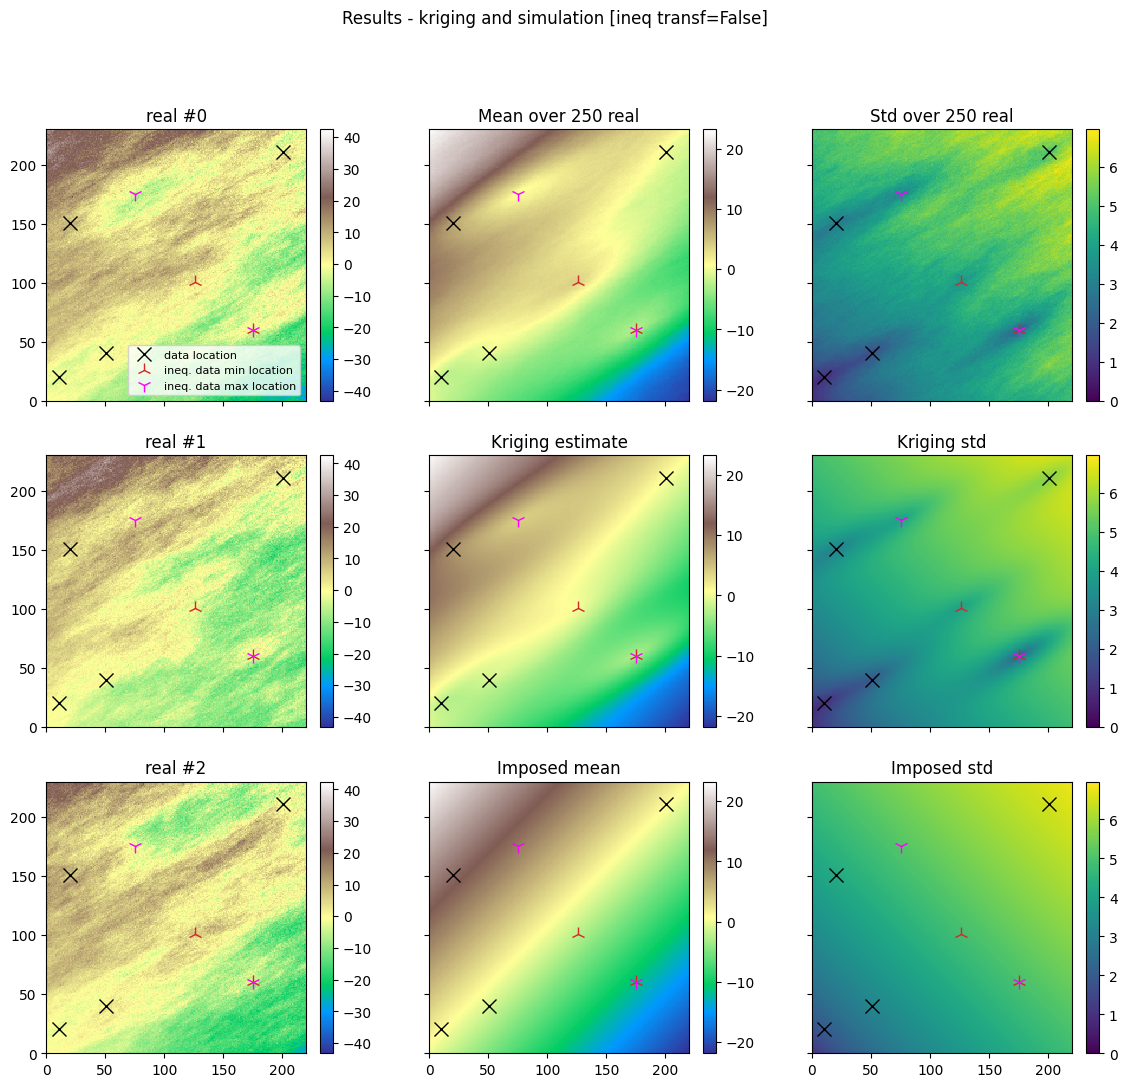

In [36]:
# Plot simulations and kriging results
im_mean = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=1, val=im.val[0])
im_std = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=1, val=np.sqrt(im.val[1]))

vmin = simul_img.val.min()
vmax = simul_img.val.max()

mean_min = min(simul_img_mean.val.min(), krig_img.val[0].min(), im_mean.val.min())
mean_max = max(simul_img_mean.val.max(), krig_img.val[0].max(), im_mean.val.max())

std_min = min(simul_img_std.val.min(), krig_img.val[1].min(), im_std.val.min())
std_max = max(simul_img_std.val.max(), krig_img.val[1].max(), im_std.val.max())

cmap = 'terrain'
cmap_mean = 'terrain'
cmap_std = 'viridis'

def plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max):
    if x is not None:
        # add data
        plt.plot(x[:,0],x[:,1], 'x', c='k', alpha=1.0, markersize=10, label='data location')
    if x_ineq is not None:
         # add inequality data, lower bound
        label = 'ineq. data min location'
        for i, vv in enumerate(v_ineq_min): 
            if not np.isnan(vv):
                plt.plot(*x_ineq[i], '2', c='tab:red', alpha=1.0, markersize=10, label=label)
                label = None
        # add inequality data, upper bound
        label = 'ineq. data max location'
        for i, vv in enumerate(v_ineq_max):
            if not np.isnan(vv):
                plt.plot(*x_ineq[i], '1', c='magenta', alpha=1.0, markersize=10, label=label)
                label = None

fig, ax = plt.subplots(3, 3, figsize=(14, 12), sharex=True, sharey=True)
# 3 first real ...
for i in (0, 1, 2):
    plt.subplot(3, 3, 3*i+1)
    gn.imgplot.drawImage2D(simul_img, iv=i, cmap=cmap, vmin=vmin, vmax=vmax)
    plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
    plt.title(f'real #{i}')
    if i == 0:
        plt.legend(fontsize=8)

# mean
plt.subplot(3, 3, 2)
gn.imgplot.drawImage2D(simul_img_mean, iv=0, cmap=cmap_mean, vmin=mean_min, vmax=mean_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Mean over {nreal} real')

# std
plt.subplot(3, 3, 3)
gn.imgplot.drawImage2D(simul_img_std, iv=0, cmap=cmap_std, vmin=std_min, vmax=std_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Std over {nreal} real')

# kriging estimate
plt.subplot(3, 3, 5)
gn.imgplot.drawImage2D(krig_img, iv=0, cmap=cmap_mean, vmin=mean_min, vmax=mean_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Kriging estimate')

# kriging std
plt.subplot(3, 3, 6)
gn.imgplot.drawImage2D(krig_img, iv=1, cmap=cmap_std, vmin=std_min, vmax=std_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Kriging std')

# Imposed mean
plt.subplot(3, 3, 8)
gn.imgplot.drawImage2D(im_mean, cmap=cmap_mean, vmin=mean_min, vmax=mean_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Imposed mean')

# Imposed std
plt.subplot(3, 3, 9)
gn.imgplot.drawImage2D(im_std, cmap=cmap_std, vmin=std_min, vmax=std_max)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Imposed std')

plt.suptitle(f'Results - kriging and simulation [ineq transf={mode_transform_ineq_to_data}]')
plt.show()

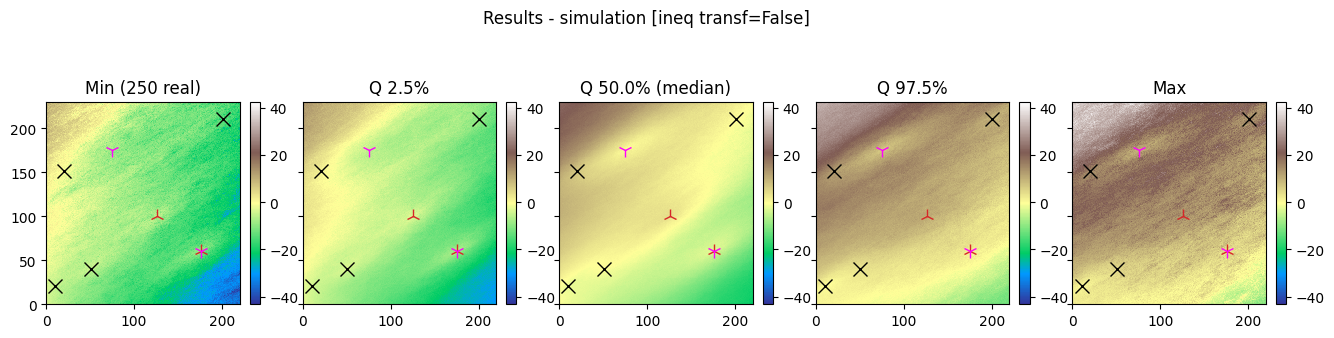

In [37]:
# Plot min, max, and quantiles of simulations
fig, ax = plt.subplots(1, 5, figsize=(16,4), sharex=True, sharey=True)

# min
plt.subplot(1, 5, 1)
gn.imgplot.drawImage2D(simul_img_min, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Min ({nreal} real)')

# Q
plt.subplot(1, 5, 2)
gn.imgplot.drawImage2D(simul_img_q, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Q {100*q[0]:.1f}%')

plt.subplot(1, 5, 3)
gn.imgplot.drawImage2D(simul_img_q, iv=1, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Q {100*q[1]:.1f}% (median)')

plt.subplot(1, 5, 4)
gn.imgplot.drawImage2D(simul_img_q, iv=2, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Q {100*q[2]:.1f}%')

# max
plt.subplot(1, 5, 5)
gn.imgplot.drawImage2D(simul_img_max, iv=0, cmap=cmap, vmin=vmin, vmax=vmax)
plot_data_in_2d(x, x_ineq, v_ineq_min, v_ineq_max)
plt.title(f'Max')

plt.suptitle(f'Results - simulation [ineq transf={mode_transform_ineq_to_data}]')
plt.show()

### Check results
For each data point and inequality data point, the results obtained at the center of the grid cell containing the point are checked for
kriging (estimate or mean, with inequality data transform into data with error), and simulation (with or without ineq. data transform).

**Note:** Conditioning is "fully honoured" 
- for data points: located **exactly** in a cell center and with a **zero data error**
- for inequality data points: located **exactly** in a cell center and with `mode_transform_ineq_to_data=False`

In [38]:
# Check data
# ----------
if x is not None:
    # Get data error std (array)
    data_err_std = np.atleast_1d(v_err_std)
    if data_err_std.size==1:
        data_err_std = np.ones_like(v)*data_err_std[0]

    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], 0, sx, sy, 1., ox, oy, 0.) for xk in x] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the data points
    x_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix]] for ix, iy, iz in data_grid_index])
    # Distance to center cell
    dist_to_x_center = np.sqrt(np.sum((np.asarray(x) - np.asarray(x_center))**2, axis=1))

    # Check
    for j in range(len(x)):
        print(f'Data point index {j}, dist. to cell center = {dist_to_x_center[j]:.4g}')
        ix, iy, iz = data_grid_index[j]                      # grid index of cell containing the data point
        krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]  # kriging estimate and std at cell center
        sim_v = simul_img.val[:, iz, iy, ix]                 # simulated values at cell center
        print(f'   data value                         = {v[j]:.3e} [data error std = {data_err_std[j]:.3e}]')
        print(f'   krig. mean value [ineq transf=True] = {krig_v_mu:.3e} [krig. std = {krig_v_std:.3e}]')
        print(f'   simul. [ineq transf={str(mode_transform_ineq_to_data):<5}]   : mean = {sim_v.mean() :.3e}, min = {sim_v.min() :.3e}, max = {sim_v.max() :.3e} [std = {sim_v.std() :.3e}]')


Data point index 0, dist. to cell center = 0
   data value                         = -3.000e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = -3.000e+00 [krig. std = 0.000e+00]
   simul. [ineq transf=False]   : mean = -3.000e+00, min = -3.000e+00, max = -3.000e+00 [std = 0.000e+00]
Data point index 1, dist. to cell center = 0.4061
   data value                         = 2.000e+00 [data error std = 0.000e+00]
   krig. mean value [ineq transf=True] = 1.212e+00 [krig. std = 1.394e+00]
   simul. [ineq transf=False]   : mean = 2.027e-01, min = -2.731e+00, max = 3.603e+00 [std = 1.028e+00]
Data point index 2, dist. to cell center = 0.4776
   data value                         = 5.000e+00 [data error std = 3.000e-01]
   krig. mean value [ineq transf=True] = 5.440e+00 [krig. std = 1.964e+00]
   simul. [ineq transf=False]   : mean = 6.545e+00, min = 1.141e+00, max = 1.302e+01 [std = 2.498e+00]
Data point index 3, dist. to cell center = 0.2408
   data value               

In [39]:
# Check inequality data
# ---------------------
if x_ineq is not None:
    # Get index of conditioning location in the grid
    ineq_data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], 0, sx, sy, 1., ox, oy, 0.) for xk in x_ineq] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the inequality data points
    x_ineq_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix]] for ix, iy, iz in ineq_data_grid_index])
    # Distance to center cell
    dist_to_x_ineq_center = np.sqrt(np.sum((np.asarray(x_ineq) - np.asarray(x_ineq_center))**2, axis=1))

    # Check
    for j in range(len(x_ineq)):
        print(f'Ineq. data point index {j}, dist. to cell center = {dist_to_x_ineq_center[j]:.4g}')
        ix, iy, iz = ineq_data_grid_index[j]     # grid index of cell containing the inequality data point
        krig_v_mu = krig_img.val[0, iz, iy, ix]  # kriging estimate at cell center
        sim_v = simul_img.val[:, iz, iy, ix]     # simulated values at cell center
        if not np.isnan(v_ineq_min[j]) and not np.isinf(v_ineq_min[j]):
            print(f'   does kriging mean value respect ineq data min [ineq transf=True] : {krig_v_mu >= v_ineq_min[j]}')
            print(f'   percentage of simul. respecting ineq data min [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v >= v_ineq_min[j]):.3f}%')
        if not np.isnan(v_ineq_max[j]) and not np.isinf(v_ineq_max[j]):
            print(f'   does kriging mean value respect ineq data max [ineq transf=True] : {krig_v_mu <= v_ineq_max[j]}')
            print(f'   percentage of simul. respecting ineq data max [ineq transf={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v <= v_ineq_max[j]):.3f}%')


Ineq. data point index 0, dist. to cell center = 0
   does kriging mean value respect ineq data min [ineq transf=True] : True
   percentage of simul. respecting ineq data min [ineq transf=False]: 100.000%
   does kriging mean value respect ineq data max [ineq transf=True] : True
   percentage of simul. respecting ineq data max [ineq transf=False]: 100.000%
Ineq. data point index 1, dist. to cell center = 0.5522
   does kriging mean value respect ineq data min [ineq transf=True] : True
   percentage of simul. respecting ineq data min [ineq transf=False]: 51.600%
Ineq. data point index 2, dist. to cell center = 0.2193
   does kriging mean value respect ineq data max [ineq transf=True] : False
   percentage of simul. respecting ineq data max [ineq transf=False]: 11.200%
